# Análisis y procesamiento de la señal de habla

In [77]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtp
import matplotlib.patches as mpatches

SIZE_FACTOR = 2

mtp.rcParams['figure.figsize'] = (13, 5)
mtp.rcParams['figure.dpi'] = 150

## 1) Grafique la señal de voz del archivo hh15.wav, ubicando en ella porciones de señales que se o correspondan con fonemas sonoros y sordos. Segmentar y etiquetar en forma aproximada cada uno del los fonemas presentes en la señal.

Fonemas a mano por Gastón en `Letter.LETTERS_POSITION`

Rate: 16000 | Muestras: 54656 | Duracion 3.416s | Duracion/Muestras = 6.25e-05


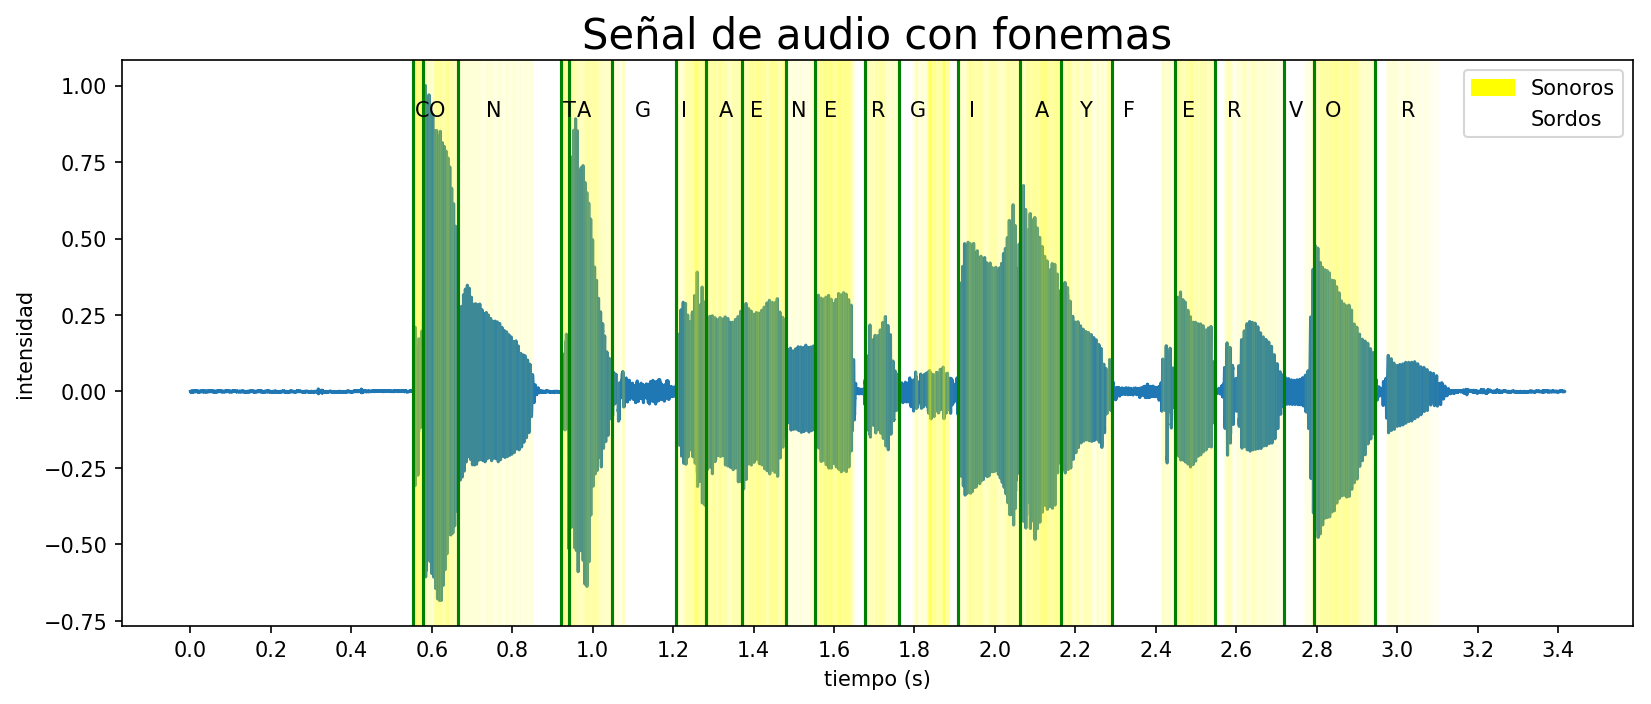

In [78]:
from scipy.io import wavfile
from tp.vocal import Letter

(FS, Y) = wavfile.read("res/hh15.WAV")

# Duracion
L = len(Y)/FS
print("Rate: {} | Muestras: {} | Duracion {}s | Duracion/Muestras = {}".format(FS, len(Y), L, L/len(Y)))

X = np.arange(0, len(Y))/FS
Y_max = max(Y)
Y = Y/Y_max # Y normalizado

plt.title(r'Señal de audio con fonemas', fontsize=20)
plt.plot(X, Y) 
plt.xticks(np.arange(min(X), max(X), 0.2))

UMBRAL = 0.05
inicia_mudo = False
for x, v in zip(X,Y):
    v = abs(v)
    if inicia_mudo and v > UMBRAL:
        plt.axvline(x=x, alpha=0.05, color="yellow")
        inicia_mudo = False
    if v <= UMBRAL and not inicia_mudo:
        inicia_mudo = True    

red_patch = mpatches.Patch(color='yellow', label='Sonoros')
white_patch = mpatches.Patch(color='white', label='Sordos')
plt.legend(handles=[red_patch,white_patch])

plt.xlabel('tiempo (s)')
plt.ylabel('intensidad')

for l in Letter.LETTERS_POSITION:
    y = 0.9
    x = l.start + (l.end - l.start)*.35
    plt.text(x, y, l.char)
    plt.axvline(x=l.start, color="green")

plt.show()

## 2) Con la segmentación realizada en el ejercicio 1 de la señal hh15.wav, encuentre los coeficientes de Fourier de un período del segmento de señal correspondiente a un fono [a]. Repetir el cálculo para varios períodos de la vocal.


``Propuesta``
A partir de una Letra, se grafica su señal y se marca un periodo de la misma. Luego se extrae el segment (periodo) y se le realiza DFT. Apartir de la misma se extraen los coeficientes de Fourier y se grafican.



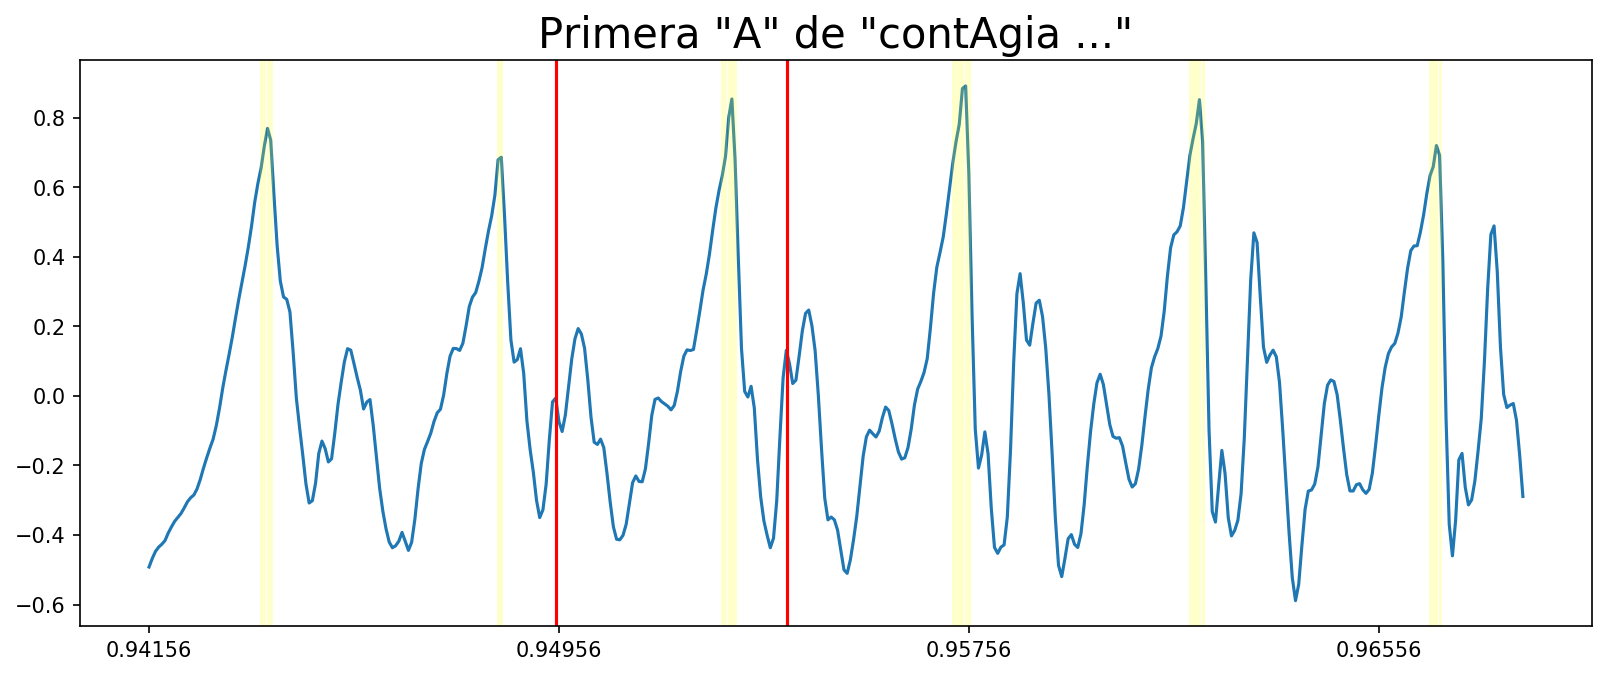

In [95]:
# Tomo a
a1 = Letter.LETTERS_POSITION[4]

def plot_letter(letter: Letter, tittle = None, **kwargs):
    X_l = X[int(letter.start*FS):int(letter.end*FS)]
    Y_l = Y[int(letter.start*FS):int(letter.end*FS)]

    graph_half = kwargs.get('graph_half', False)
    X_middle = X_l[:len(X_l)//2] if graph_half else X_l
    Y_middle = Y_l[:len(Y_l)//2] if graph_half else Y_l

    plt.title(kwargs.get("title","Letra {}".format(letter.char)), fontsize=20)
    plt.plot(X_middle, Y_middle)
    
    plt.xticks(np.arange(min(X_middle), max(X_middle), kwargs.get('xticks',0.008)))
    
    # Marco ls picos mas altos
    for x, y in zip(X_middle, Y_middle):
        if y > kwargs.get('threeshold', max(Y_middle)*.70):
            x = plt.axvline(x=x, color="yellow", alpha=0.2)
    return X_l, Y_l
    

(X_a1, Y_a1) = plot_letter(a1, title=r'Primera "A" de "contAgia ..."', graph_half=True)

# Busco periodo "a mano"
plt.axvline(x=0.9495, color="red")
plt.axvline(x=0.9495 + 0.00451, color="red")

plt.show()

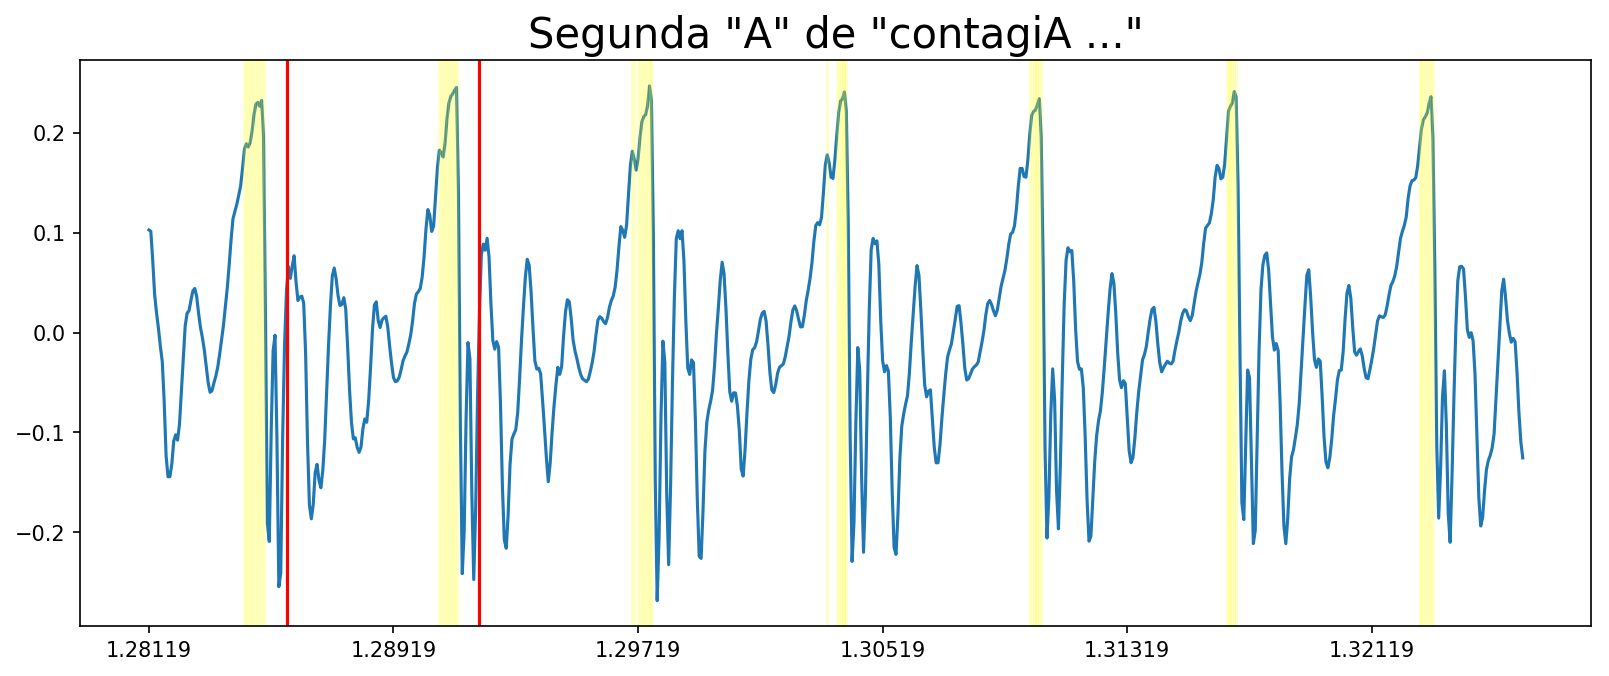

In [98]:
a2 = Letter.LETTERS_POSITION[7]

(X_a2, Y_a2) = plot_letter(a2, title=r'Segunda "A" de "contagiA ..."', graph_half=True)
# Busco periodo "a mano"
plt.axvline(x=a2.start + 0.0045, color="red")
plt.axvline(x=a2.start + 0.0045 + 0.00628, color="red")

plt.show()

### Busco periodo de primera A Manualmante

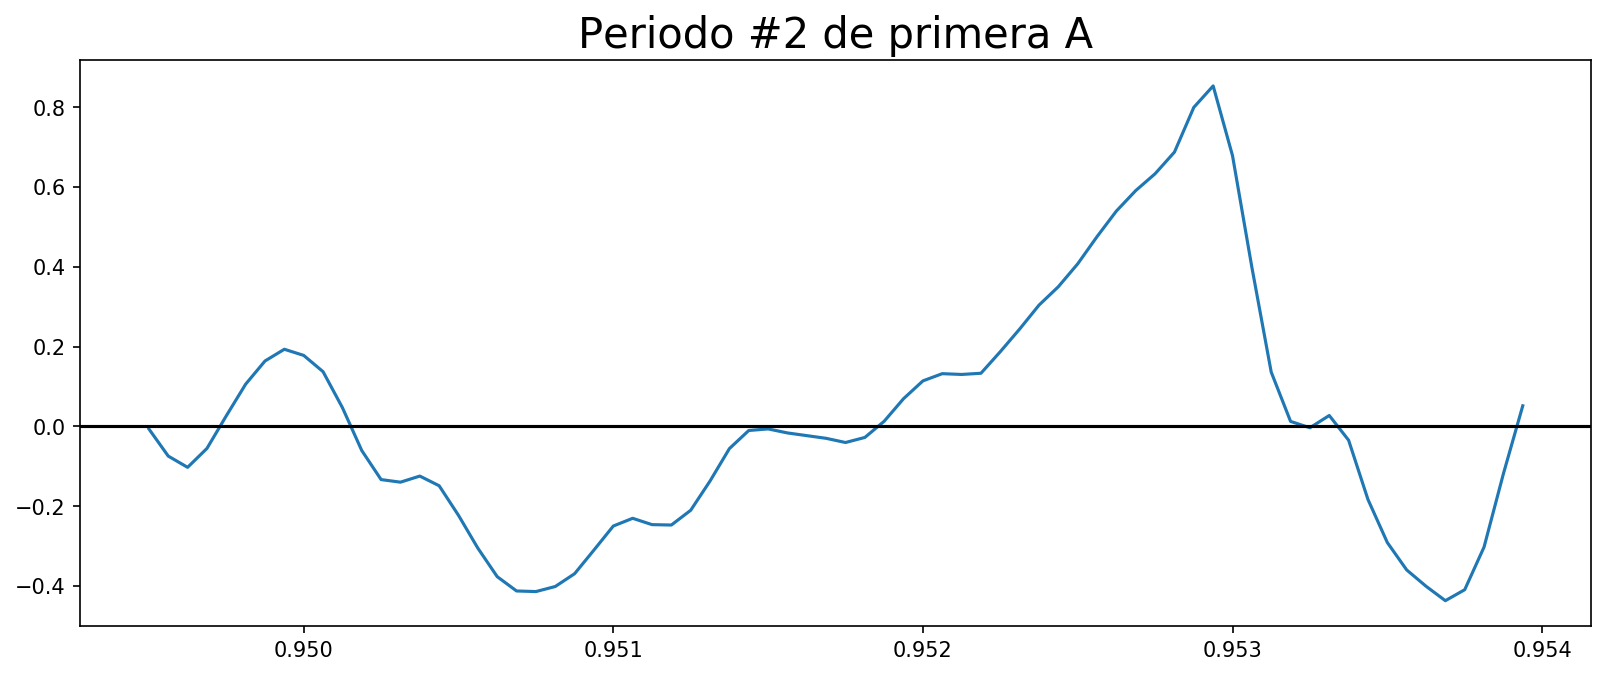

In [81]:
a1_T = 0.0045 # Tamano del periodo de "a1"

# Periodo 2
a1_P2_start = 0.9495

X_a1_P2 = X[int(a1_P2_start*FS):int((a1_P2_start + a1_T)*FS)]
Y_a1_P2 = Y[int(a1_P2_start*FS):int((a1_P2_start + a1_T)*FS)]

# print("Y[ 0]: {}\nY[-1]: {}\nDiferencia: {}".format(Y_a1_T[0], Y_a1_T[-1], abs(Y_a1_T[0]-Y_a1_T[-1])))

plt.title(r'Periodo #2 de primera A', fontsize=20)
plt.plot(X_a1_P2, Y_a1_P2)
plt.axhline(y=0, color="black")
plt.show()

### FFT del Periodo 2 de primera A

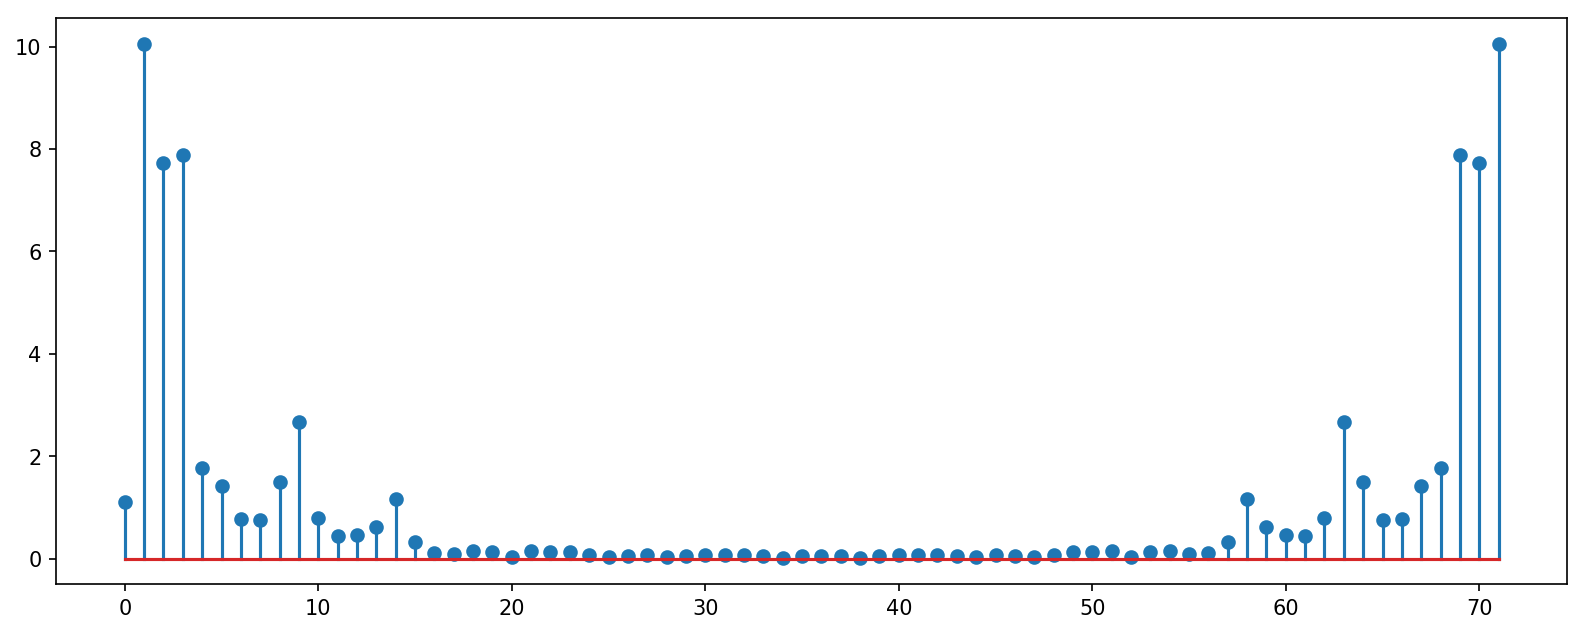

In [82]:
# Calclo DFT (con FFT). Desnormalizo el vector Y
TF_Y_a1_P2 = np.fft.fft(np.array(Y_a1_P2)*max(Y))
plt.stem(np.absolute(TF_Y_a1_P2))
plt.show()

## 3) Reconstruya la señal temporal a partir de los coeficientes calculados. Escuche y compare las distintas reconstrucciones correspondientes a coeficientes de Fourier tomados de distintos períodos. Compárelas también con la señal original. ¿Qué observación se puede hacer sobre la periodicidad de los fonemas vocálicos?


A los resultados obtenidos en el punto anteriro, se realiza la inversa de la DFT (ifft) y se la hace `tile` para reptir el segmento por un tiempo breve (~2 segundos). Ese resultado se vuelva sobre un archivo WAV.


In [83]:
# Reconstruyo la señal usando inversa de fft
Yr_a1_P2 = np.tile(np.real(np.fft.ifft(TF_Y_a1_P2)), 500)
wavfile.write("out/a1-t1.wav", FS, Yr_a1_P2)
print("Out: \"{}\" [Duracion: {} seg., FS:{}, Muestras: {}]"
      .format("out/a1.wav", len(Yr_a1_P2)/FS, FS, len(Yr_a1_P2/FS))
     )

Out: "out/a1.wav" [Duracion: 2.25 seg., FS:16000, Muestras: 36000]


## 4) Grabe la misma frase del ejercicio 1. Mencionar las diferencias entre ambas señales.

La grabacion se realiza en Audacity. Y se debe conseguir la sincronizacion optima respecto del sonido original.

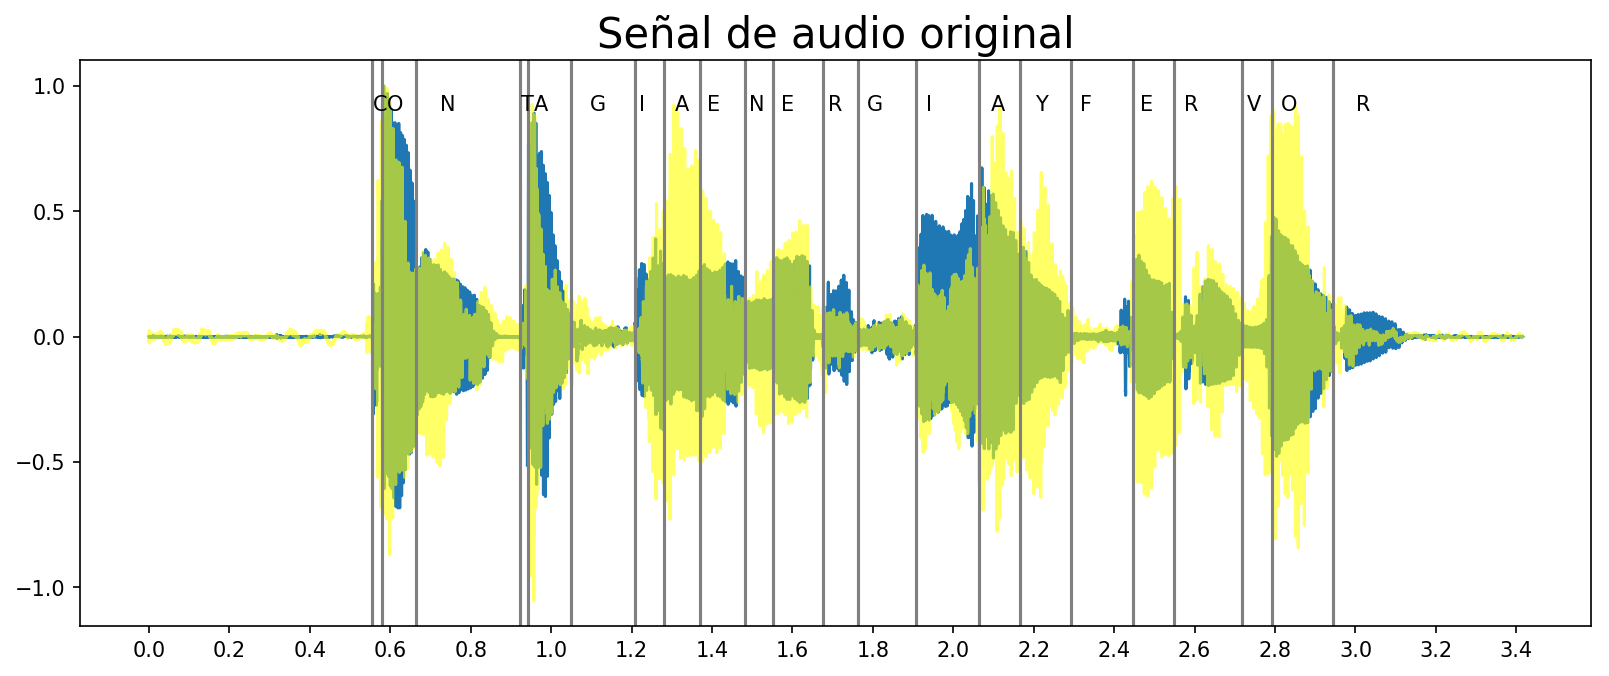

In [84]:
# Plot de original
X = np.arange(0, len(Y))/FS
Y = Y/max(Y) # Y normalizado
plt.title(r'Señal de audio original', fontsize=20)
plt.plot(X, Y) 
plt.xticks(np.arange(min(X), max(X), 0.2))

# Senal grabada
(FS_t, Y_t) = wavfile.read("res/hh15-self.wav")
X_t = np.arange(0, len(Y_t))/FS_t
Y_t = Y_t/max(Y_t) # Y normalizado 
plt.plot(X_t, Y_t, alpha=0.6, color="yellow")
for l in Letter.LETTERS_POSITION:
    y = 0.9
    x = l.start + (l.end - l.start)*.3
    plt.text(x, y, l.char)
    plt.axvline(x=l.start, color="grey")
plt.show()

A simple vista se ntan mayor intensidad de la señal en las vocales "A" y "E". Debe notarse tambien, la menor intensidad en la "I" de energia.

*TODO: Exponer diferencias entre la voz de una mujer y un hombre*

## 5) Grafique los espectrogramas de banda angosta de los segmentos de señal correspondientes a tres vocales presentes en la señal hh15.wav. Compare y analice las diferencias.

### Selecciono 3 vocales
"c**O**ntag**I**a en**E**rgia y fervor"

 

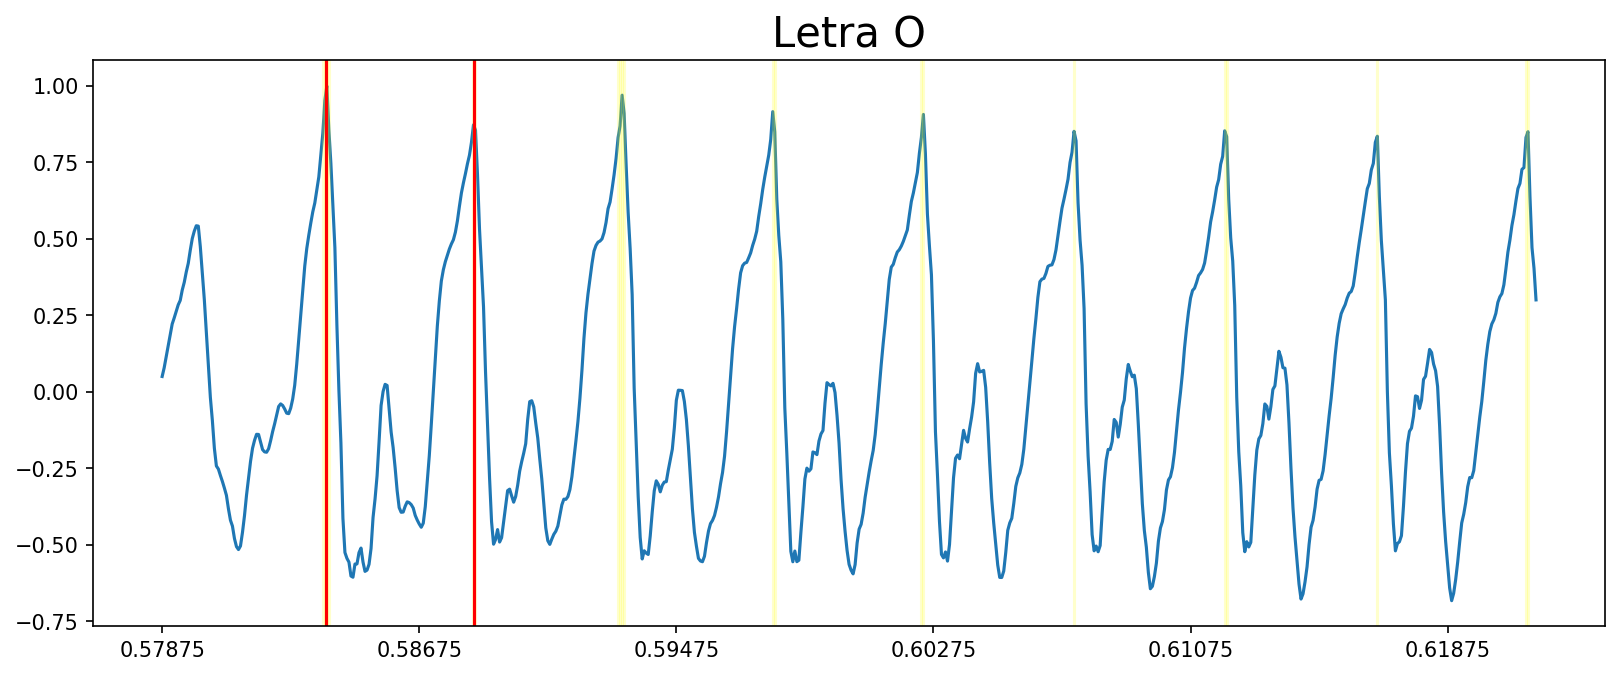

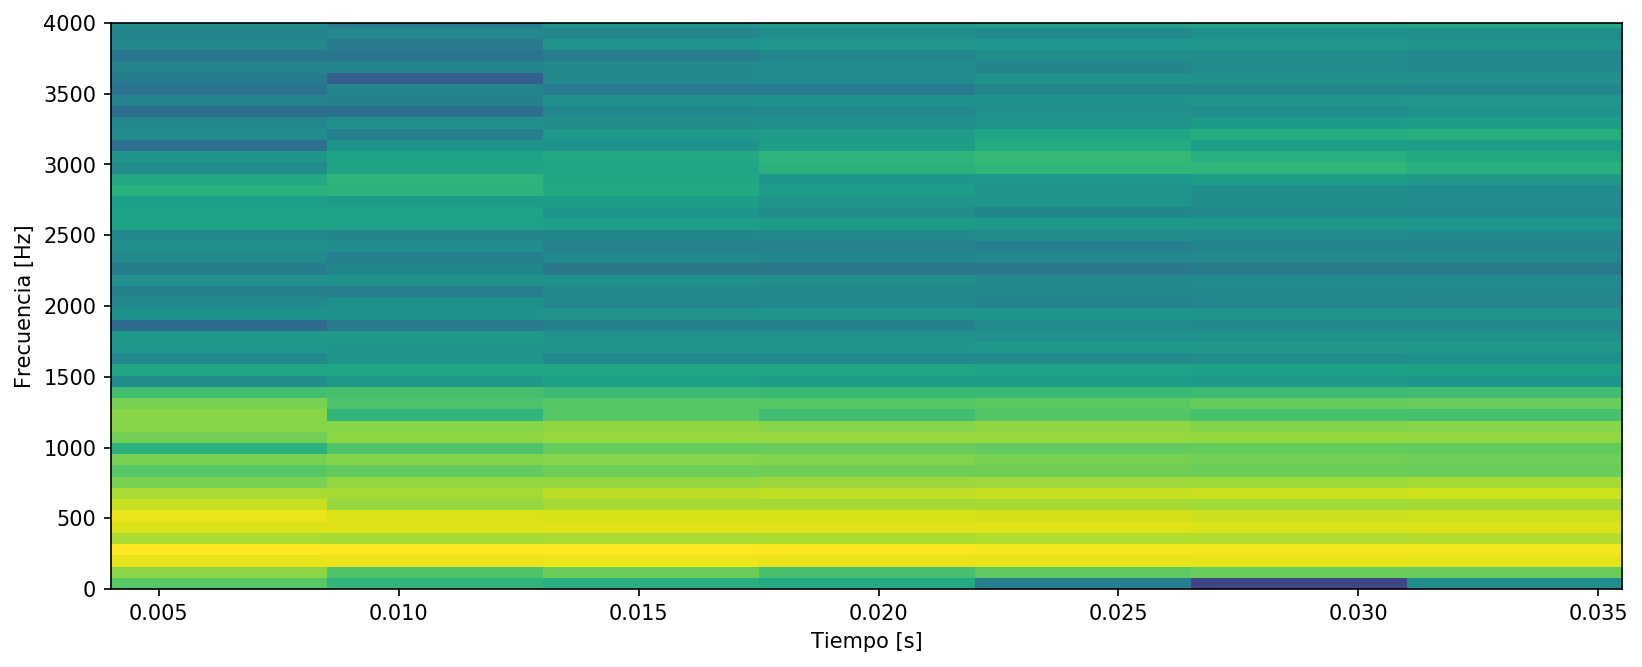

In [99]:
from scipy import signal

O1 = Letter.LETTERS_POSITION[1]
(O1_X, O1_Y) = plot_letter(O1, r'Primera "O" de "cOntagia ..."', threeshold=0.83)

plt.axvline(x=0.58385, color="red")
plt.axvline(x=0.58385 + 0.00460, color="red")

plt.show()

O1_P = 0.00460
# NFFT: T de un periodo x cantidad = Ancho de ventana
plt.specgram(O1_Y*Y_max, NFFT=200, Fs=FS)
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.ylim(0, 4e3)
plt.show()

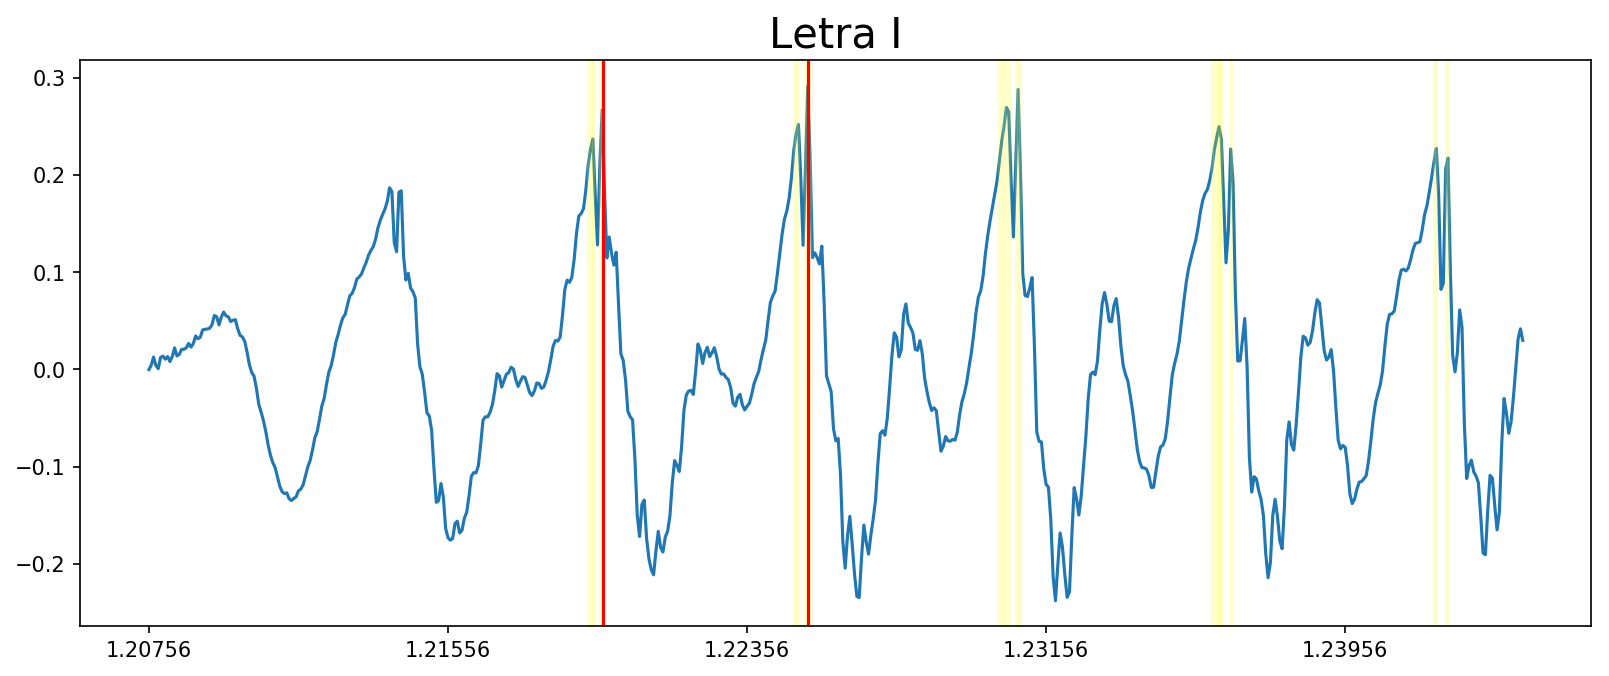

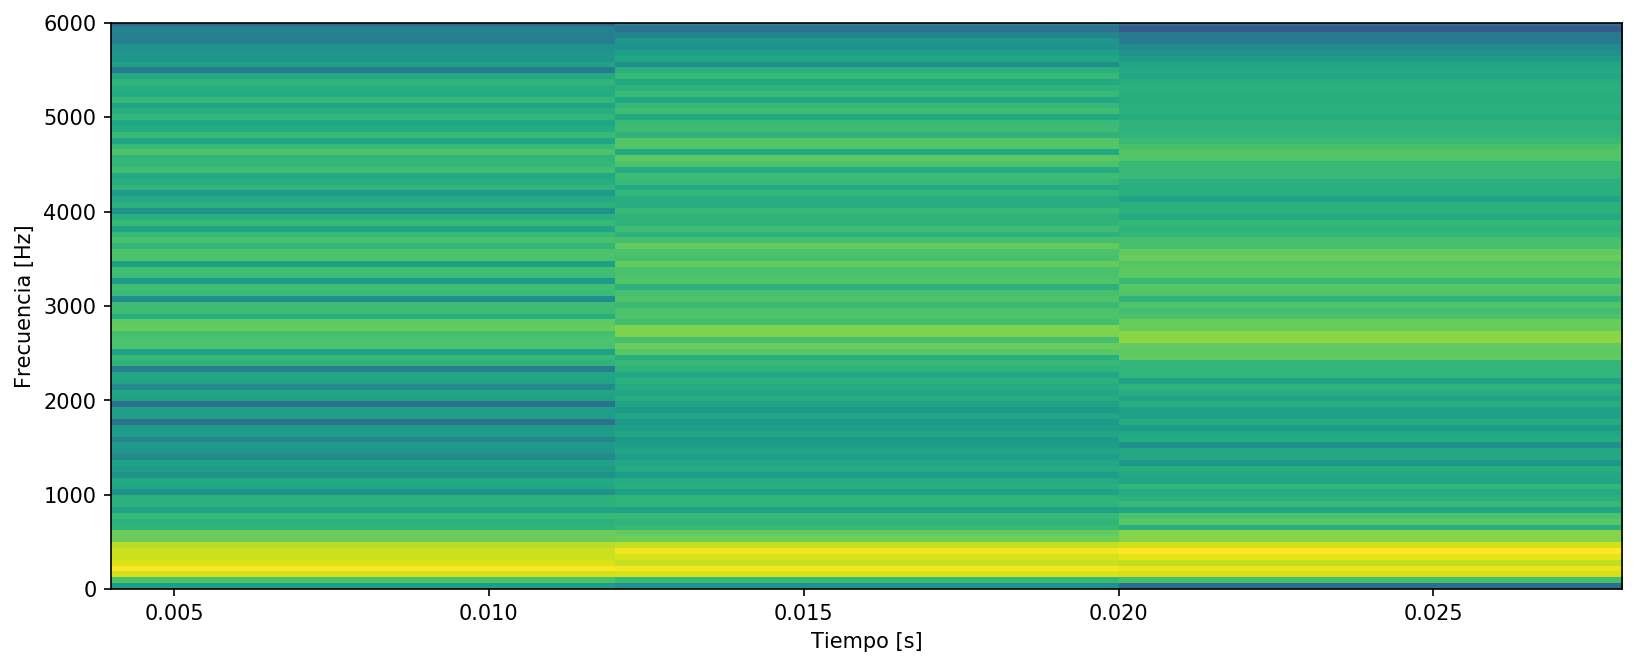

In [109]:
I1 = Letter.LETTERS_POSITION[6]
(I1_X, I1_Y) = plot_letter(I1, r'Primera "I" de "contagIa ..."')

plt.axvline(x=1.21970, color="red")
plt.axvline(x=1.21970 + 0.005481, color="red")

plt.show()

I1_P = 0.005481
# NFFT: T de un periodo x cantidad = Ancho de ventana
plt.specgram(I1_Y*Y_max, NFFT=256, Fs=FS)
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.ylim(0, 6e3)
plt.show()

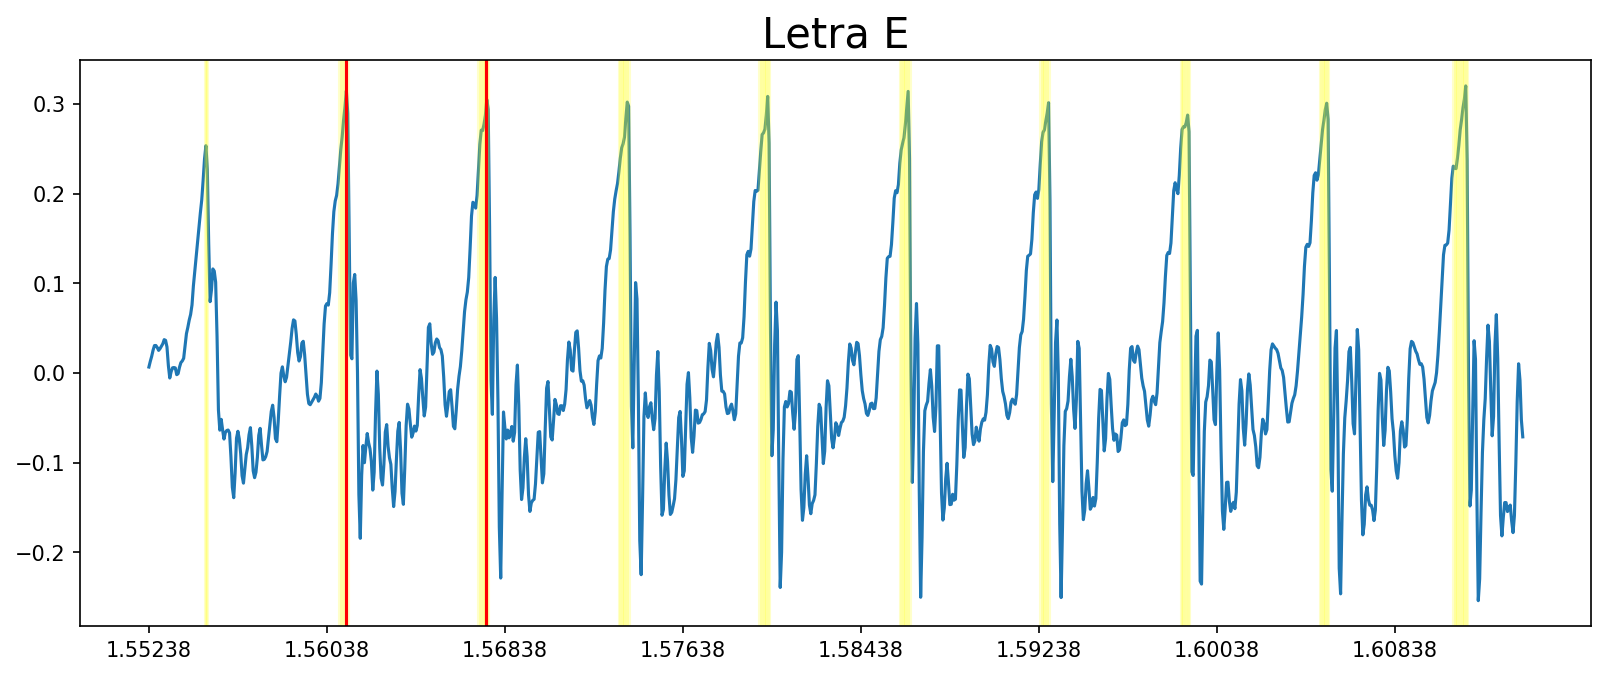

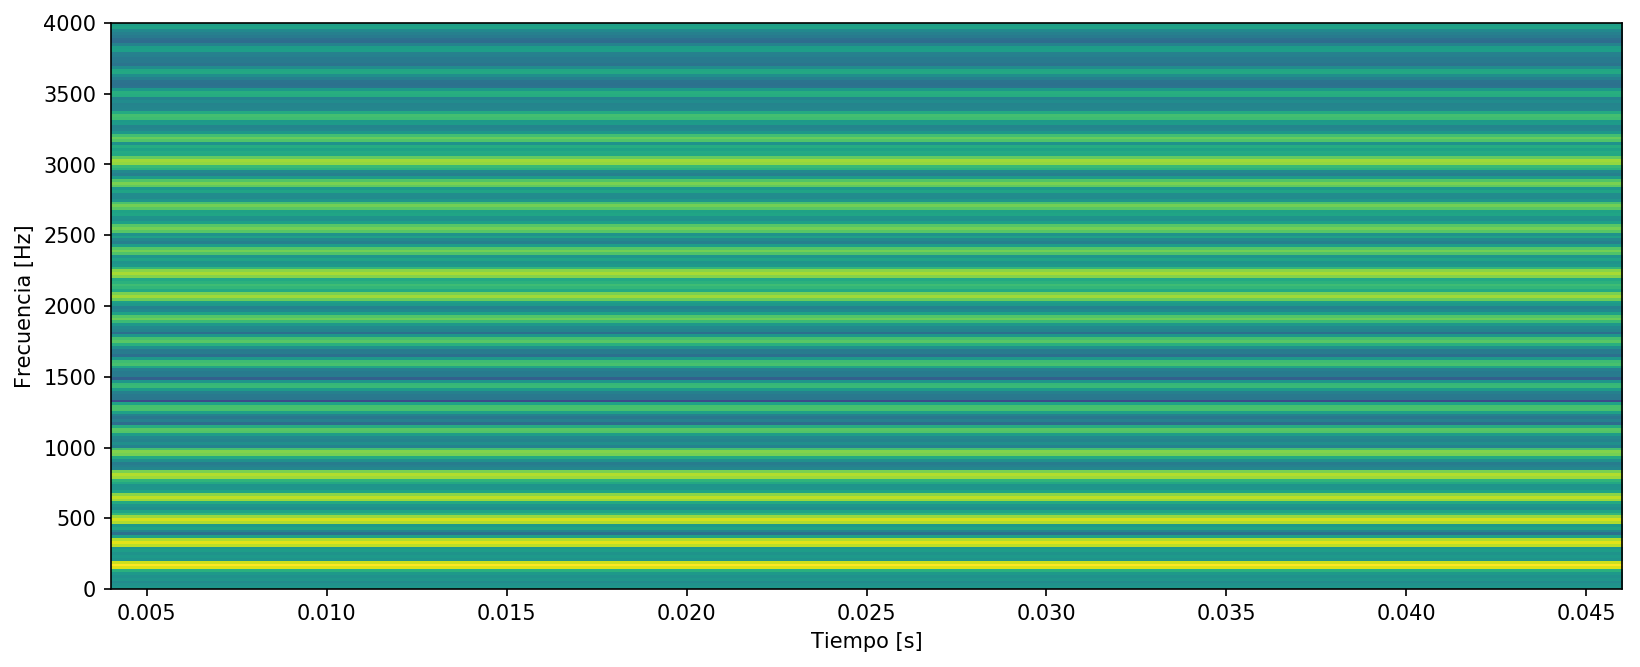

In [181]:
E2 = Letter.LETTERS_POSITION[10]
(E2_X, E2_Y) = plot_letter(E2, r'Segunda "E" de "... enErgia ..."')


plt.axvline(x=1.56125, color="red")
plt.axvline(x=1.56125 + 0.006281, color="red")

plt.show()

E2_P = 0.006281
# NFFT: T de un periodo x cantidad = Ancho de ventana
plt.specgram(E2_Y*Y_max, NFFT=800, Fs=FS)
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.ylim(0, 4e3)
plt.show()

``banda angosta`` Se puede notar como el ancho de la ventana afecta la resulicion temporal. Es decir, mientras mas ancha, menor resolucion temporal y mayor resulcion espectral.

```
Otros Parametros:
- **x** : (1-D array) containing the data.

- **Fs** : (scalar) The sampling frequency (samples per time unit). It is used to calculate the Fourier frequencies, freqs, in cycles per time unit. The default value is 2.

- **window** : (callable or ndarray) A function or a vector of length NFFT. To create window vectors see window_hanning(), window_none(), numpy.blackman(), numpy.hamming(), numpy.bartlett(), scipy.signal(), scipy.signal.get_window(), etc. The default is window_hanning(). If a function is passed as the argument, it must take a data segment as an argument and return the windowed version of the segment.

- **sides** : [ ‘default’ | ‘onesided’ | ‘twosided’ ] Specifies which sides of the spectrum to return. Default gives the default behavior, which returns one-sided for real data and both for complex data. ‘onesided’ forces the return of a one-sided spectrum, while ‘twosided’ forces two-sided.

- **pad_to** : (integer) The number of points to which the data segment is padded when performing the FFT. This can be different from NFFT, which specifies the number of data points used. While not increasing the actual resolution of the spectrum (the minimum distance between resolvable peaks), this can give more points in the plot, allowing for more detail. This corresponds to the n parameter in the call to fft(). The default is None, which sets pad_to equal to NFFT

- **NFFT** : (integer) The number of data points used in each block for the FFT. A power 2 is most efficient. The default value is 256. This should NOT be used to get zero padding, or the scaling of the result will be incorrect. Use pad_to for this instead.

- **detrend** : {‘default’, ‘constant’, ‘mean’, ‘linear’, ‘none’} or callable. The function applied to each segment before fft-ing, designed to remove the mean or linear trend. Unlike in MATLAB, where the detrend parameter is a vector, in matplotlib is it a function. The pylab module defines detrend_none(), detrend_mean(), and detrend_linear(), but you can use a custom function as well. You can also use a string to choose one of the functions. ‘default’, ‘constant’, and ‘mean’ call detrend_mean(). ‘linear’ calls detrend_linear(). ‘none’ calls detrend_none().

- **scale_by_freq** : boolean, optional Specifies whether the resulting density values should be scaled by the scaling frequency, which gives density in units of Hz^-1. This allows for integration over the returned frequency values. The default is True for MATLAB compatibility.

- **mode** : [ ‘default’ | ‘psd’ | ‘magnitude’ | ‘angle’ | ‘phase’ ] What sort of spectrum to use. Default is ‘psd’, which takes the power spectral density. ‘complex’ returns the complex-valued frequency spectrum. ‘magnitude’ returns the magnitude spectrum. ‘angle’ returns the phase spectrum without unwrapping. ‘phase’ returns the phase spectrum with unwrapping.

- **noverlap** : integer - The number of points of overlap between blocks. The default value is 128.

- **scale** : [ ‘default’ | ‘linear’ | ‘dB’ ] The scaling of the values in the spec. ‘linear’ is no scaling. ‘dB’ returns the values in dB scale. When mode is ‘psd’, this is dB power (10 * log10). Otherwise this is dB amplitude (20 * log10). ‘default’ is ‘dB’ if mode is ‘psd’ or ‘magnitude’ and ‘linear’ otherwise. This must be ‘linear’ if mode is ‘angle’ or ‘phase’.

- **Fc** : integer - The center frequency of x (defaults to 0), which offsets the x extents of the plot to reflect the frequency range used when a signal is acquired and then filtered and downsampled to baseband.

- **cmap** : - A matplotlib.colors.Colormap instance; if None, use default determined by rc

- **xextent** : [None | (xmin, xmax)] - The image extent along the x-axis. The default sets xmin to the left border of the first bin (spectrum column) and xmax to the right border of the last bin. Note that for noverlap>0 the width of the bins is smaller than those of the segments.
```

## 6) Genere diez ciclos del tren de pulsos glóticos según los modelos de Rosenberg. Tomar una frecuencia F0 = 200 Hz, y fases de apertura y cierre de 40% y 16%, respectivamente, de la duración de un pulso. Considerar una amplitud máxima de 1. A los efectos de la simulación, considerar una frecuencia de muestreo de 16 kHz. Estimar su espectro de amplitud y explicar su contenido. Grafique en forma superpuesta el espectro de un pulso y del tren de pulsos. Justifique los resultados observados.

Modelo del pulso blotico (ecuacion 1)

espectro de un periodo son deltas de dirac con envolvente


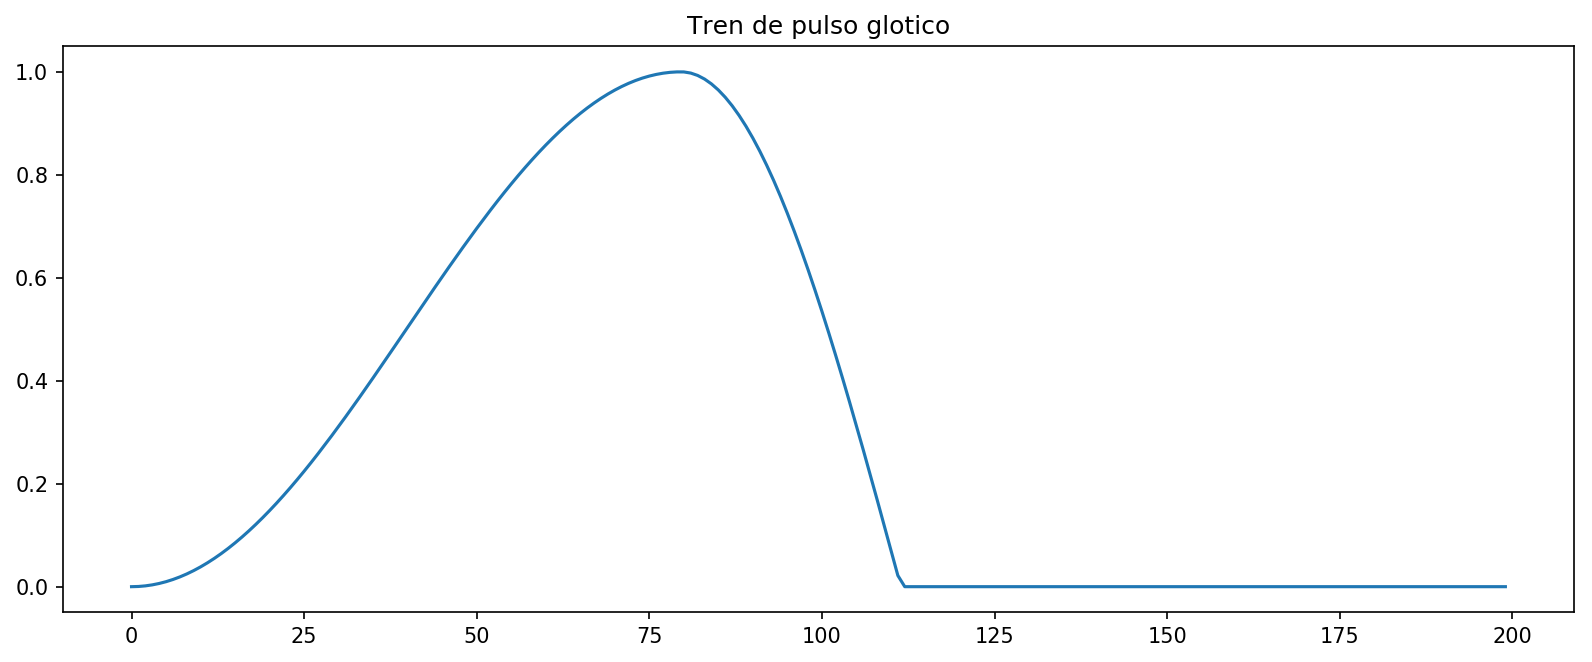

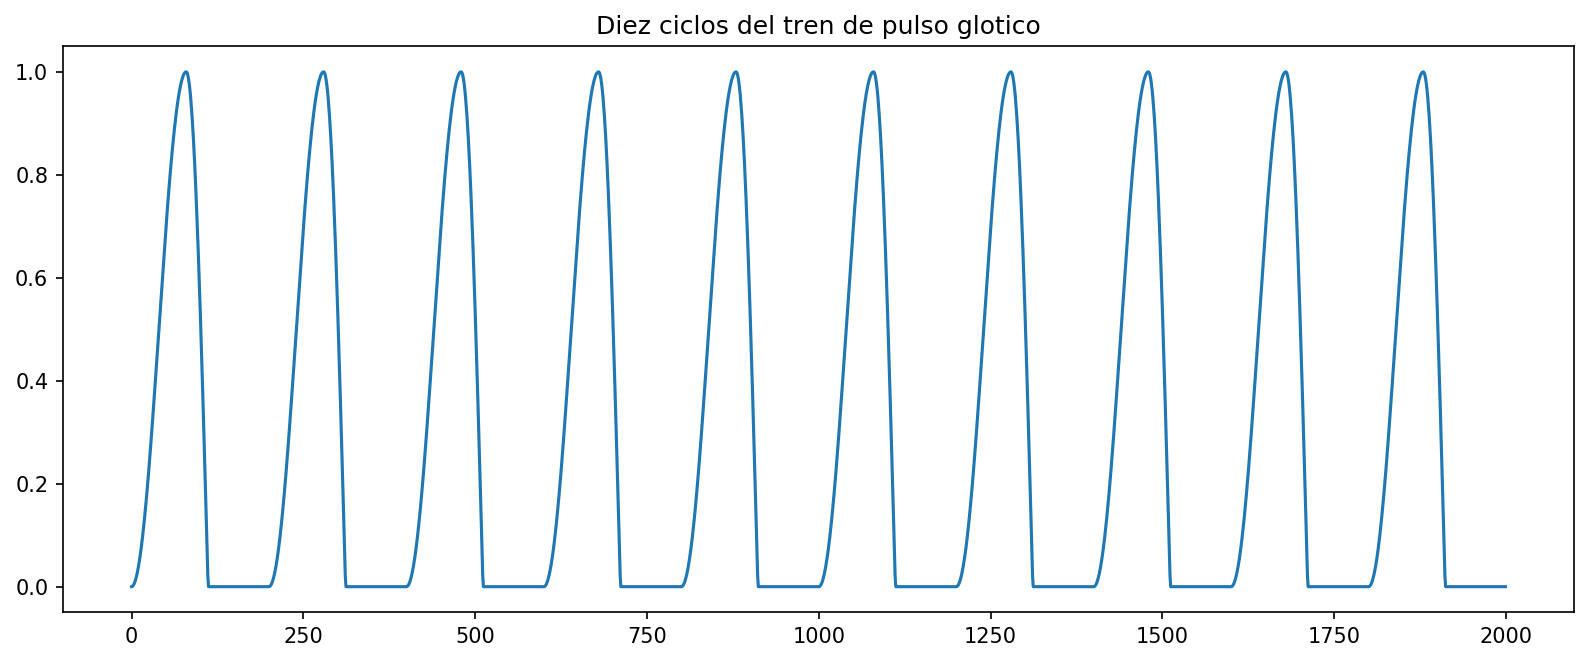

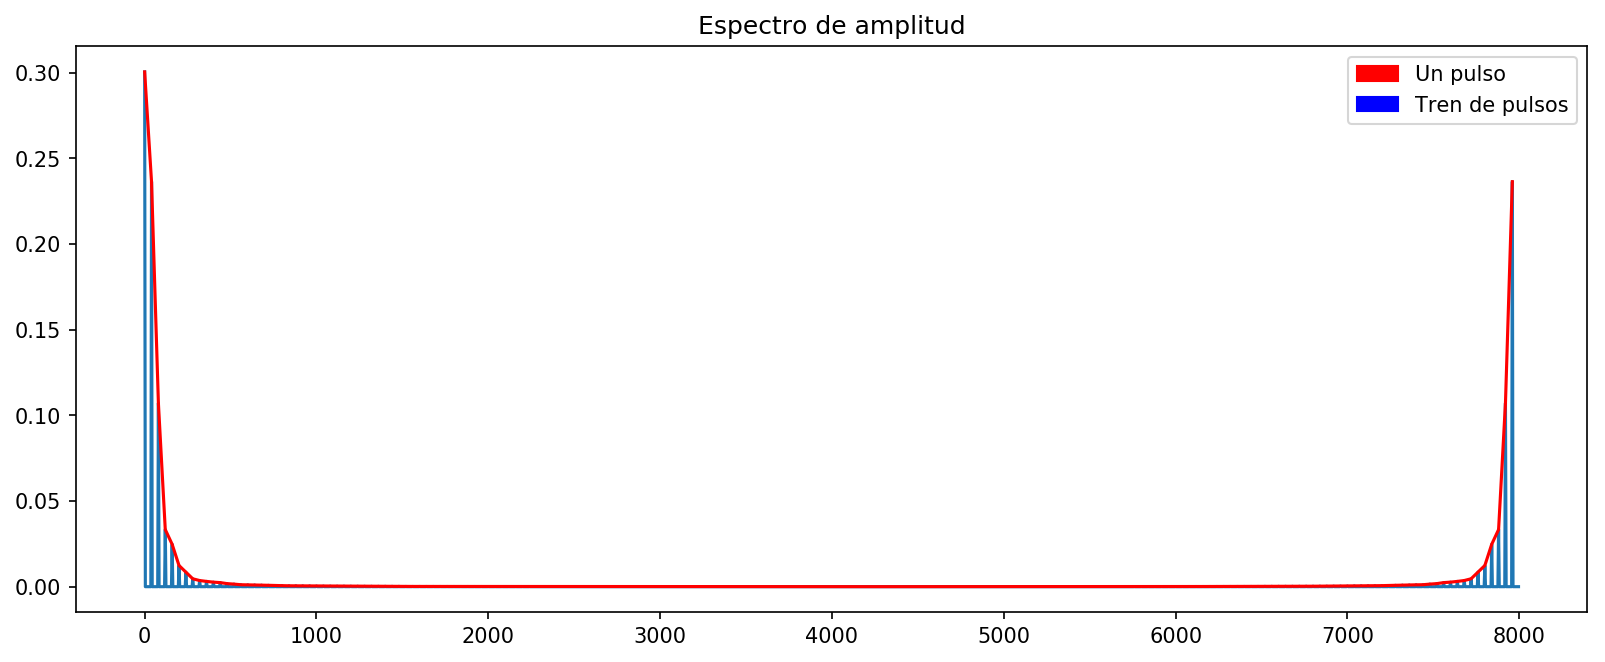

In [182]:
from tp.vocal import GlottalPulse

F06 = 200
FS6 = 16e3

T6 = np.arange(0, 1, 1/F06)
Pt = GlottalPulse.generate(max(T6)*.4, max(T6)*.16, 1)
P6 = np.array([Pt(t) for t in T6])
P6_10 = np.tile(P6, 10)

plt.plot(P6)
plt.title("Tren de pulso glotico")
plt.show()

plt.plot(P6_10)
plt.title("Diez ciclos del tren de pulso glotico")
plt.show()


AMPLITUDE_SPECTRUM = abs(np.fft.fft(P6) / len(P6))
AMPLITUDE_SPECTRUM_10 = abs(np.fft.fft(P6_10) / len(P6_10))
plt.plot(np.arange(0, FS6/2, (FS6/2)/len(AMPLITUDE_SPECTRUM_10)), AMPLITUDE_SPECTRUM_10)
plt.plot(np.arange(0, FS6/2, (FS6/2)/len(AMPLITUDE_SPECTRUM)), AMPLITUDE_SPECTRUM, color="red")
plt.title("Espectro de amplitud")
plt.legend(handles=[
    mpatches.Patch(color='red', label='Un pulso'),
    mpatches.Patch(color='blue', label='Tren de pulsos')
])
plt.show()



## 7) Utilizando las ec. 3 y 4, generar un modelo de tracto vocal para cada uno de los siguientes conjuntos de valores de parámetros, que se corresponde con una vocal emitida por una locutora. Graficar diagrama de polos y ceros, y la respuesta en frecuencia d cada vocal, compare.

|  | F1  | B1  | F2   | B2  | F3   | B3  | F4   | B4  |
|--|-----|-----|------|-----|------|-----|------|-----|
|**a**| 830 | 110 | 1400 | 160 | 2890 | 210 | 3930 | 230 |
|**e**| 500 | 80  | 2000 | 156 | 3130 | 190 | 4150 | 220 |
|**i**| 330 | 70  | 2765 | 130 | 3740 | 178 | 4336 | 200 |
|**o**| 546 | 97  | 934  | 130 | 2966 | 185 | 3930 | 240 |
|**u**| 382 | 74  | 740  | 150 | 2760 | 210 | 3380 | 180 |

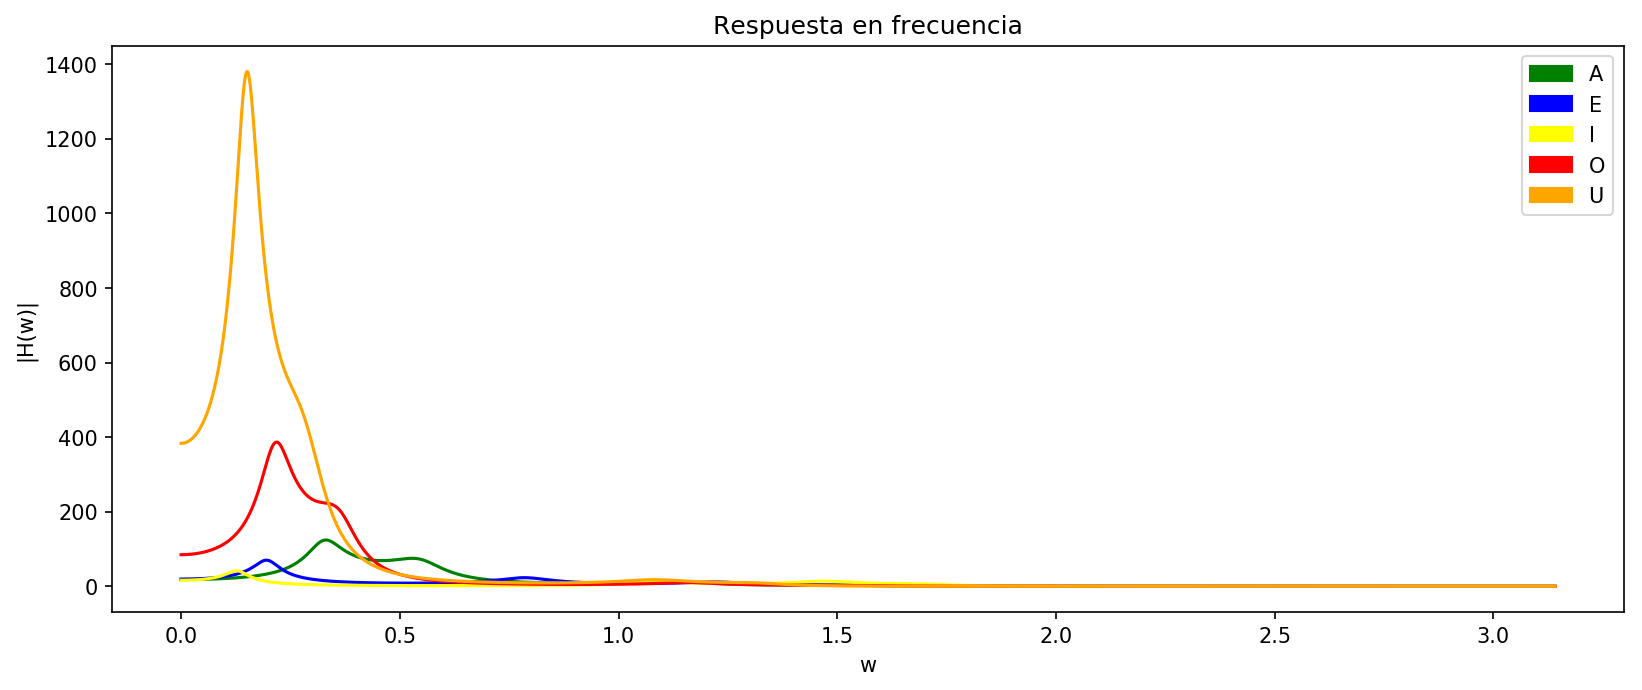

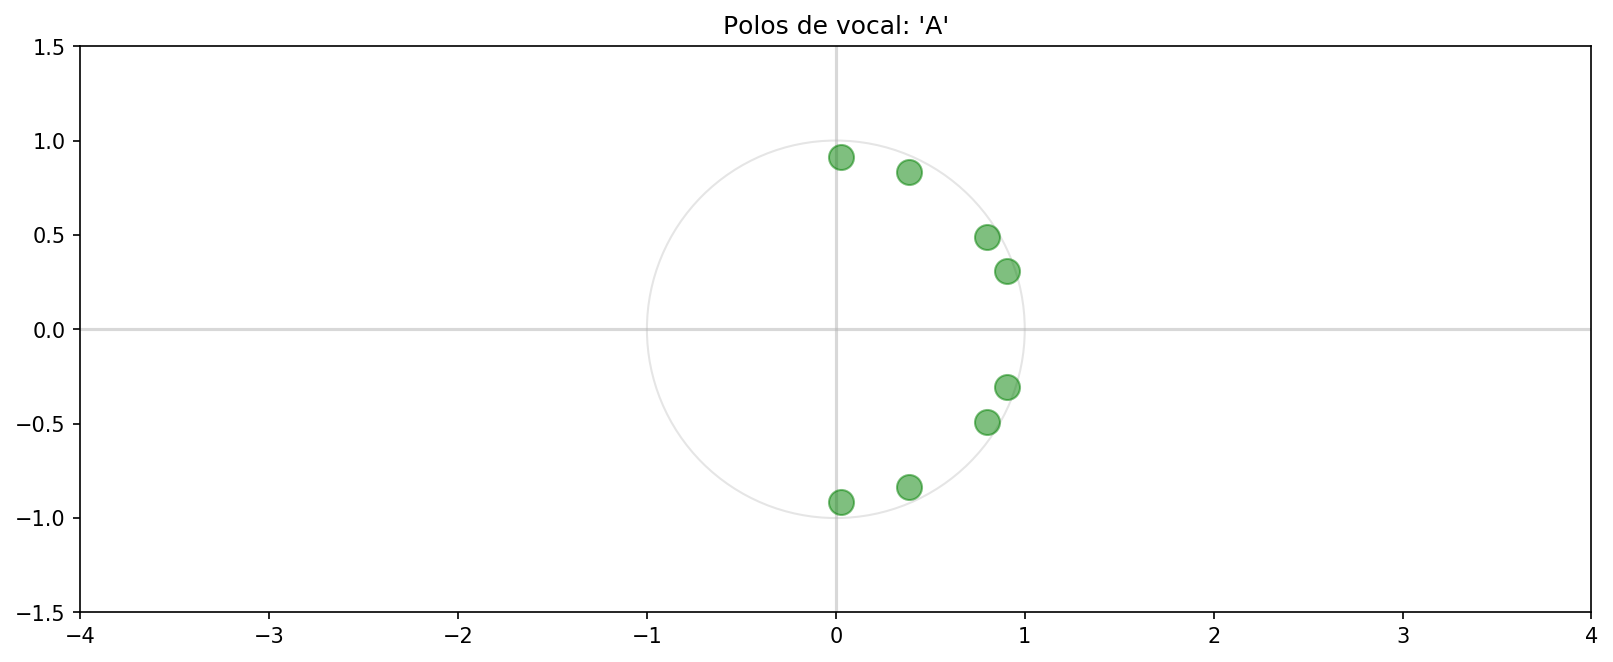

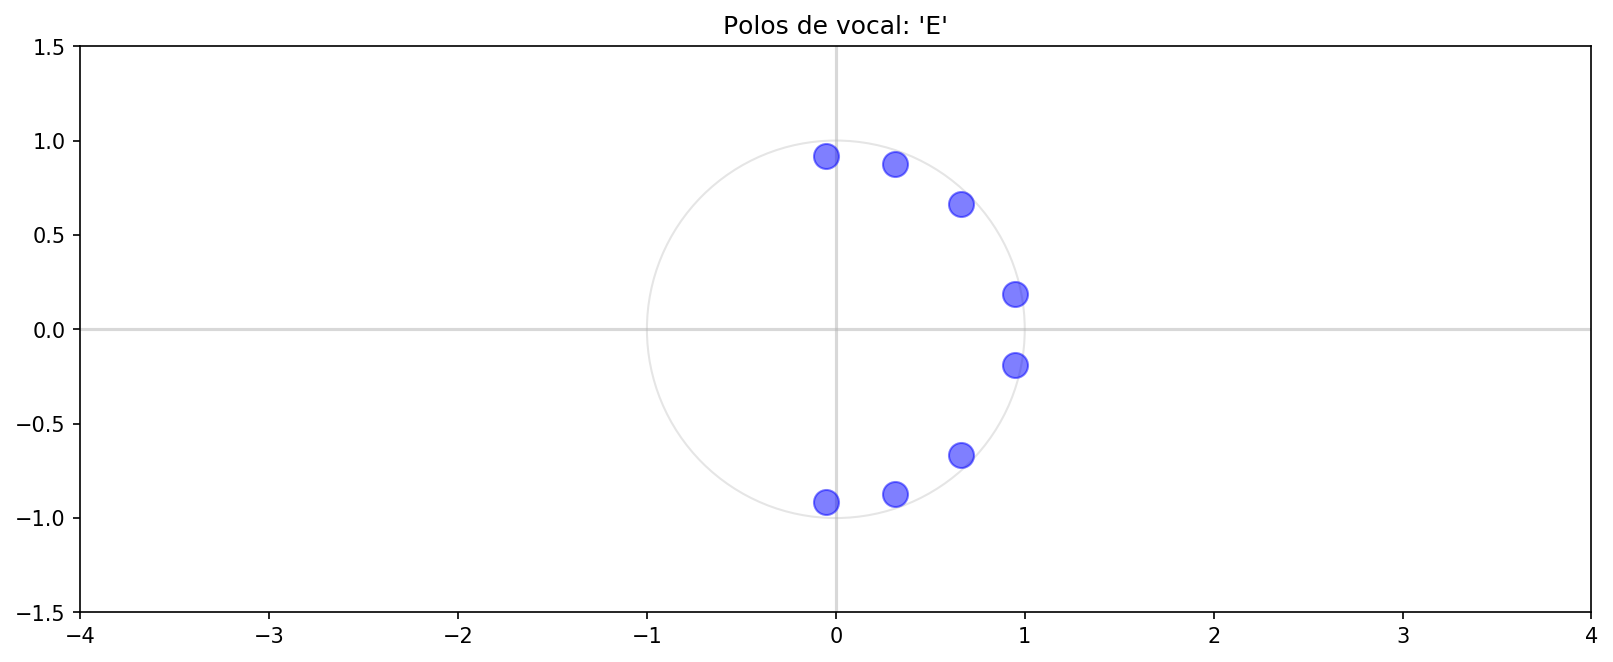

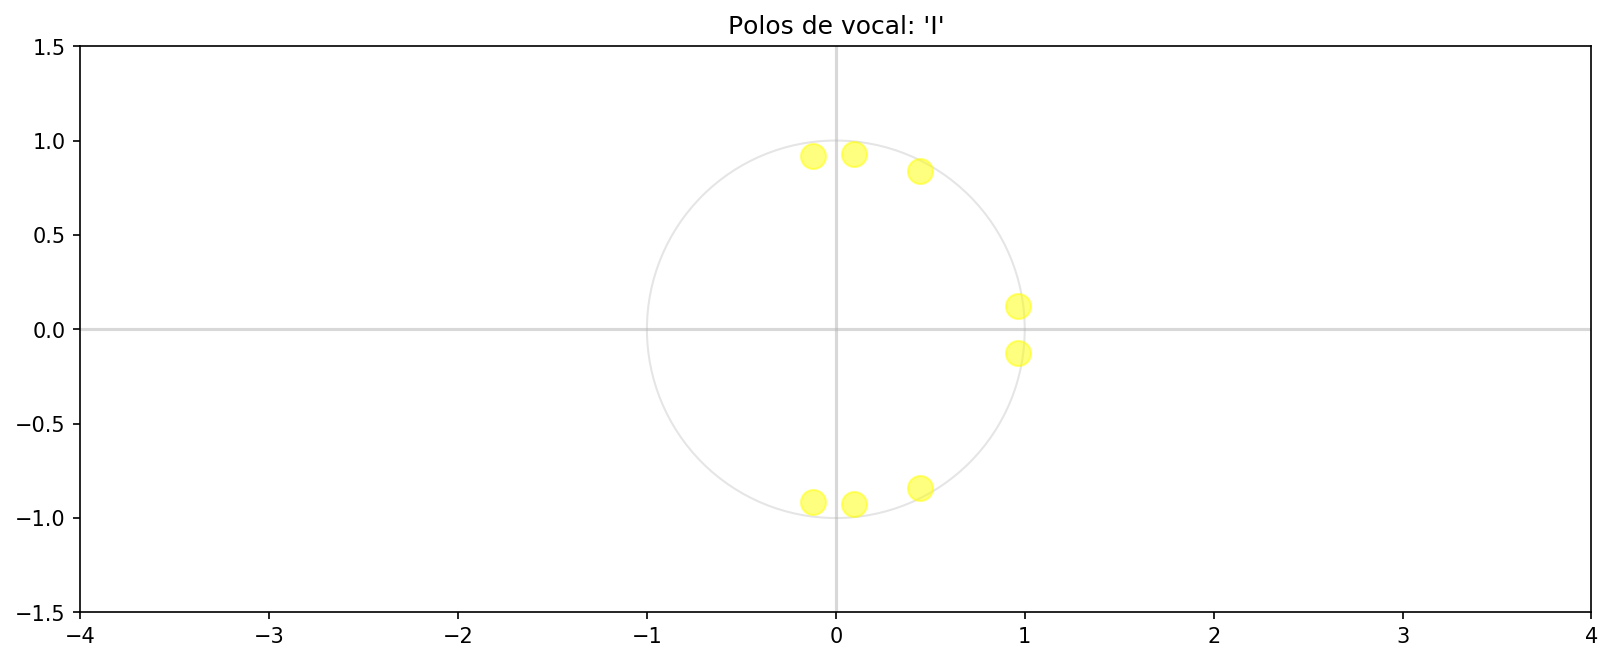

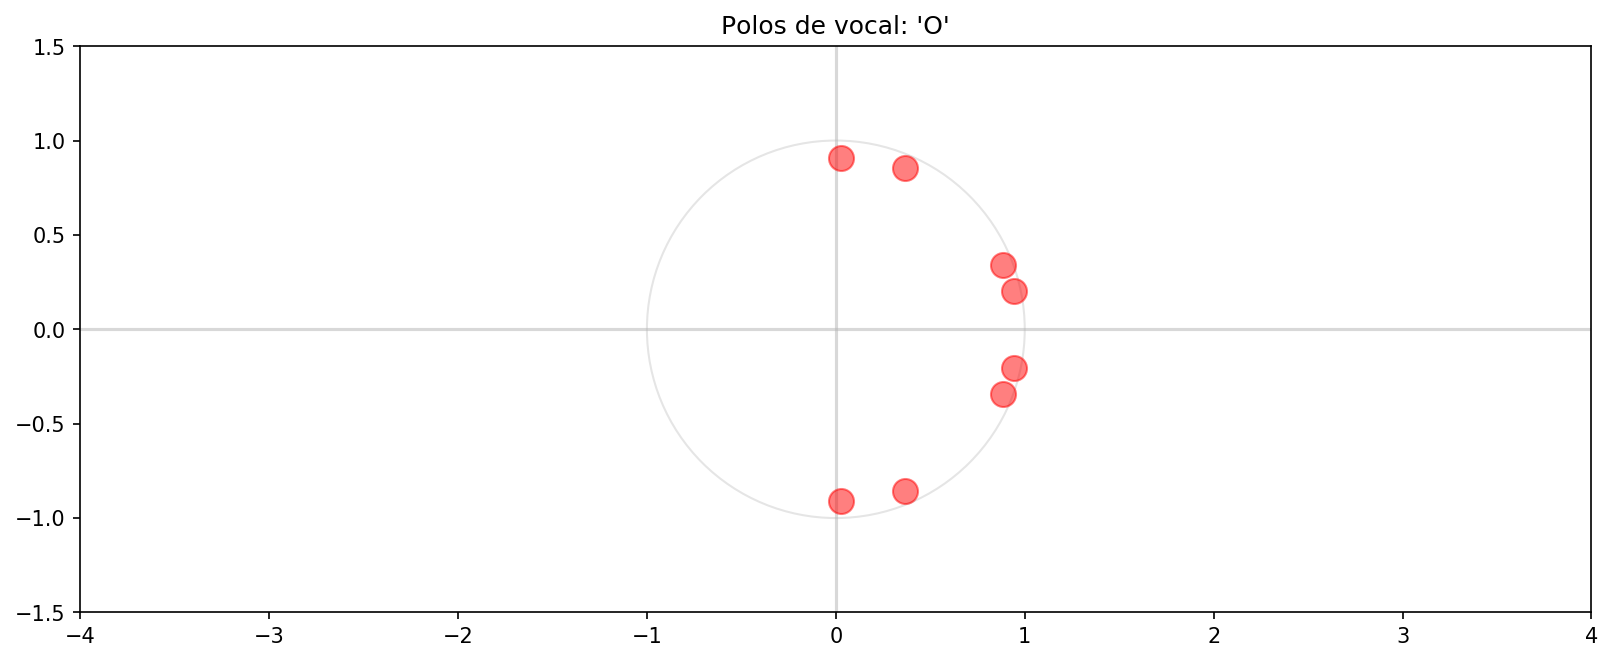

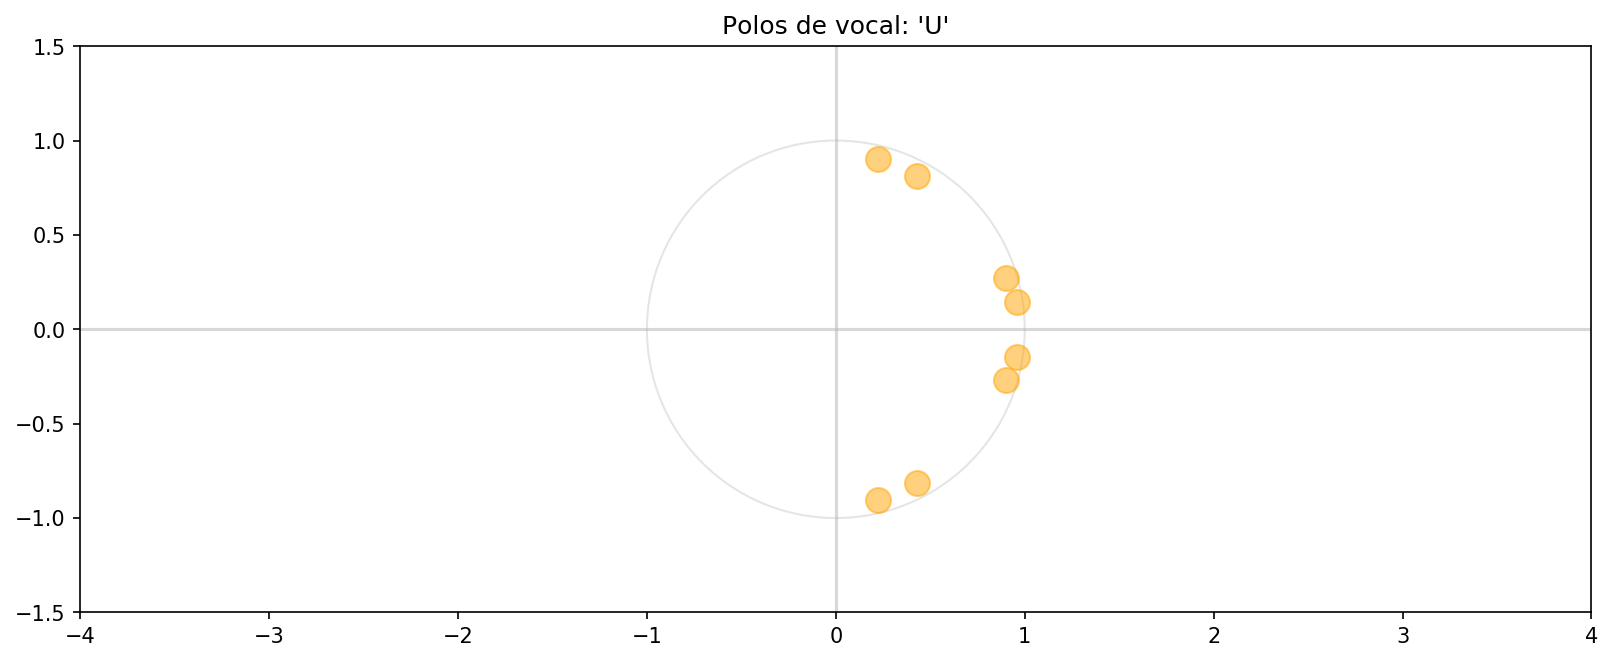

In [255]:
from tp.vocal import Tract

VOCALS = {
    'a' : {'data': [ (830,110), (1400, 160), (2890,210), (3930,230) ], 'color': 'green'},
    'e' : {'data': [ (500,80) , (2000, 156), (3130,190), (4150,220) ], 'color': 'blue'},
    'i' : {'data': [ (330,70) , (2765, 130), (3740,178), (4336,200) ], 'color': 'yellow'},
    'o' : {'data': [ (546,97) , (934, 130) , (2966,185), (3930,240) ], 'color': 'red'},
    'u' : {'data': [ (382,74) , (740, 150) , (2760,210), (3380,180) ], 'color': 'orange'},
}

# Respuesta en frecuencia

w = np.arange(0, np.pi, 0.001)
for vocal, data in VOCALS.items():
    H_cascade = 1
    for F, B in data['data']:
        H = Tract.generate(B, F, FS) #G
        H_cascade *= H(z = np.exp(1j*w))
    plt.plot(w, np.abs(H_cascade), color=data['color'])
plt.title("Respuesta en frecuencia")
plt.xlabel("w")
plt.ylabel("|H(w)|")
plt.legend(handles=[mpatches.Patch(color=d['color'], label=v.upper()) for v,d in VOCALS.items()])
plt.show()

# Diagrama de polos y ceros
for vocal, data in VOCALS.items():
    fig, ax = plt.subplots()
    ax.add_artist(plt.Circle((0,0), 1, fill=False, color='black', ls='solid', alpha=0.1))
    plt.title("Polos de vocal: '{}'".format(vocal.upper()))
    plt.axvline(0, color='0.7', alpha=0.5)
    plt.axhline(0, color='0.7', alpha=0.5)
    #plt.axis('scaled')
    plt.axis([-4, 4, -1.5, 1.5])
    poles = np.array(sum([[Tract.PN(B,F,FS), np.conj(Tract.PN(B,F,FS))] for F, B in data['data']], []))
    plt.plot(poles.real, poles.imag, 'o', markersize=12, alpha=0.5, color=data['color'])
plt.show()


## 8) Utilizando los resultados de los dos último ejercicios, sintetice un segundo de las cinco vocales. Escuche y grafique. Haga un análisis en frecuencia, y en tiempo-frecuencia.


- Y = Pos del max(|C(n)|) en Hz
- X = t


## 9) A partir de las vocales sintetizadas del ejercicio anterior, estime la respuesta en frecuencia correspondiente al tracto vocal y el contorno de la frecuencia fundamental mediante la transformada cepstrum.

## 10) Utilizando nuevamente la transformada cepstrum, estime el contorno de la frecuencia fundamental de la voz en el archivo hh15.wav. Grafique en forma sincrónica con la onda.

## 11) Aplique el método PSOLA para aumentar y disminuir un 10%, 20% y 30% la frecuencia fundamental de la voz en el archivo hh15.wav. Para ello utilice la curva de frecuencia fundamental obtenida en el ejercicio anterior.

## 12) Aplique el método PSOLA para aumentar y disminuir un 10%, 20% y 30% la duración de la voz en el archivo hh15.wav. Para ello utilice la curva de frecuencia fundamental obtenida en el ejercicio anterior.

## 13) Modifique la frecuencia fundamental de las vocales sintetizadas del ejercicio 8 desde 200 a 300 Hz en forma lineal. Escuche la onda resultante, ¿cómo se percibe el cambio en la frecuencia fundamental? Estime el F0 resultante y compárelo con el teórico.

## 14) Repita el ejercicio anterior pero esta vez variando la frecuencia fundamental desde 200 a 100 Hz.

## 15) Aplique un filtro a las vocales sintetizadas del ejercicio 8 para eliminar la frecuencia fundamental. Puede utilizar la herramienta fdatool para diseñar el filtro. Justifique el filtro implementado. Grafique ambas señales, haga un análisis en frecuencia y compare. ¿Perceptualmente se nota alguna diferencia? ¿Porqué?.